In [1]:
## Download the dataset from Kaggle
## Upload your kaggle.json to colab or just download it avoid running this cell.
!mkdir /root/.kaggle/
!mv kaggle.json /root/.kaggle/

In [2]:
!kaggle datasets download -d drgfreeman/rockpaperscissors
!unzip rockpaperscissors.zip -d rockpaperscissors

 98% 301M/306M [00:03<00:00, 98.3MB/s]
100% 306M/306M [00:03<00:00, 98.8MB/s]
Archive:  rockpaperscissors.zip
  inflating: rockpaperscissors/README_rpc-cv-images.txt  
  inflating: rockpaperscissors/paper/04l5I8TqdzF9WDMJ.png  
  inflating: rockpaperscissors/paper/0Og76sl5CJhbxWWx.png  
  inflating: rockpaperscissors/paper/0RA9rcrv8iVvuDDU.png  
  inflating: rockpaperscissors/paper/0Uomd0HvOB33m47I.png  
  inflating: rockpaperscissors/paper/0a3UtNzl5Ll3sq8K.png  
  inflating: rockpaperscissors/paper/0cb6cVL8pkfi4wF6.png  
  inflating: rockpaperscissors/paper/0eqArS2GgsBeqgSn.png  
  inflating: rockpaperscissors/paper/0t08v9bAaA0mXGCQ.png  
  inflating: rockpaperscissors/paper/0vugygEjxQJPr9yz.png  
  inflating: rockpaperscissors/paper/0zKU6wEhT2cDe9j0.png  
  inflating: rockpaperscissors/paper/14K62H4KG1hg5qiJ.png  
  inflating: rockpaperscissors/paper/1Dfw5FRlS4h60JPX.png  
  inflating: rockpaperscissors/paper/1Frbe8cdOdkciOBg.png  
  inflating: rockpaperscissors/paper/1Tt9U9SzrOm98Xt

In [3]:
!rm -rf rockpaperscissors/rps-cv-images
!rm -rf rockpaperscissors/README_rpc-cv-images.txt

In [4]:
!pip install torchinfo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
import os
import shutil
import math
from tqdm.auto import tqdm
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
import torchinfo

In [6]:
class DirectorySetup:
    def __init__(self, raw_path: str, test_size: float=0.1, val_size: float=0.1) -> None:
        self.raw_path = os.path.join(raw_path)
        self.test_size = test_size
        self.val_size = val_size
        self.train_size = 1 - (test_size + val_size)

        self.n_files = 0
        self.n_classes = 0

        self.data_dir_names = ["train", "test", "valid"]
        self.data_dir_props = [self.train_size, self.test_size, self.val_size]

    def setup(self, preprocessed_name: str):
        self.preprocessed_dir = preprocessed_name
        if not os.path.isdir(self.preprocessed_dir):
            os.mkdir(self.preprocessed_dir)

        self.classes = os.listdir(self.raw_path)
        self.n_classes = len(self.classes)

        self._create_directories()
        self._populate_directories()

    def _create_directories(self):

        for data_type in self.data_dir_names:
            type_path = os.path.join(self.preprocessed_dir, data_type)
            if not os.path.isdir(type_path): os.mkdir(type_path)

            for cls in self.classes:
                ## create the data class path and check if a dir is already exists
                cls_path = os.path.join(self.preprocessed_dir, data_type, cls)
                if not os.path.isdir(cls_path): os.mkdir(cls_path)

    def _get_raw_class_path(self, cls: str):
        return os.path.join(self.raw_path, cls)

    def _get_class_path(self, typ: str, cls: str):
        return os.path.join(self.preprocessed_dir, typ, cls)
    
    def _get_class_size(self, typ, cls, prop):
        return int(math.floor(len(os.listdir(os.path.join(self.raw_path, cls))) * prop))

    def _populate_directories(self):
        
        self.raw_images = {
            cls: os.listdir(self._get_raw_class_path(cls))
                 for cls in self.classes
        }

        self._sizes = {
            typ: {
                cls: self._get_class_size(typ, cls, prop)
                     for cls in self.classes
            } for typ, prop in zip(self.data_dir_names, self.data_dir_props)
        }

        print(self._sizes)

        self._images = {
            typ: {
                cls: []
                     for cls in self.classes
            } for typ in self.data_dir_names
        }

        start = 0
        for typ in self.data_dir_names:
            start = 0
            for cls in self.classes:
                size = self._sizes[typ][cls]
                start = 0

                for i in range(start, start+size):
                    try:
                        img = self.raw_images[cls][i]
                        src = os.path.join(self._get_raw_class_path(cls), img)
                        dst = os.path.join(self._get_class_path(typ, cls), img)
                        self._images[typ][cls].append(img)

                        shutil.copy(src, dst)

                    except Exception as e:
                        # print(str(e))
                        pass

            start += size

        self.n_files = sum( [sum([ len(self._images[typ][cls]) for cls in self.classes ]) for typ in self.data_dir_names] )
        
    def __repr__(self):
        return "Found {} files belongs to {} Classes".format(self.n_files, self.n_classes)


In [7]:
!rm -rf /content/rockpaperscissors_cleaned

In [8]:
dir_setup = DirectorySetup("rockpaperscissors")
dir_setup.setup("rockpaperscissors_cleaned")

print(dir_setup)

{'train': {'rock': 580, 'paper': 569, 'scissors': 600}, 'test': {'rock': 72, 'paper': 71, 'scissors': 75}, 'valid': {'rock': 72, 'paper': 71, 'scissors': 75}}
Found 2185 files belongs to 3 Classes


In [9]:
BASE_DIR = "rockpaperscissors_cleaned"

train_dir = os.path.join(BASE_DIR, "train")
valid_dir = os.path.join(BASE_DIR, "valid")
test_dir  = os.path.join(BASE_DIR, "test" )

In [10]:
IMAGE_SIZE = 100

train_ds = datasets.ImageFolder(
    train_dir,
    transform=transforms.Compose([
        transforms.Resize(IMAGE_SIZE),
        transforms.CenterCrop(IMAGE_SIZE),
        transforms.RandomRotation(45.),
        transforms.RandomVerticalFlip(),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        ),
    ]),
)

valid_ds = datasets.ImageFolder(
    valid_dir,
    transform=transforms.Compose([
        transforms.Resize(IMAGE_SIZE),
        transforms.CenterCrop(IMAGE_SIZE),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        ),

    ]),
)

test_ds = datasets.ImageFolder(
    test_dir,
    transform=transforms.Compose([
        transforms.Resize(IMAGE_SIZE),
        transforms.CenterCrop(IMAGE_SIZE),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        ),
    ]),
)


In [11]:
BATCH_SIZE = 32

train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=BATCH_SIZE, shuffle=True)
test_dl  = DataLoader(test_ds , batch_size=BATCH_SIZE, shuffle=True)

In [12]:
for images, labels in train_dl:
    print(images.shape, labels.shape)
    break

torch.Size([32, 3, 100, 100]) torch.Size([32])


In [13]:
class RockPaperScissors_Model_V1(nn.Module):
    def __init__(self):
        super().__init__()

        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels= 3, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )

        self.block_2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )

        self.block_3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )
        
        in_features = self.__get_size()

        self.block_4 = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=in_features, out_features=32),
            nn.ReLU(),
            nn.Linear(in_features=32, out_features=3),
        )

    def __get_size(self):
        conv_out_shape = np.asarray(self.block_3(self.block_2(self.block_1(
            torch.rand(32, 3, IMAGE_SIZE, IMAGE_SIZE)))
        ).shape)

        return np.product(conv_out_shape[1:])

    def forward(self, x):
        out = self.block_1(x)
        out = self.block_2(out)
        out = self.block_3(out)
        out = self.block_4(out)

        return out


In [14]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device Used: ", device)

model_v1 = RockPaperScissors_Model_V1().to(device)

Device Used:  cuda


In [15]:
torchinfo.summary(model_v1, input_size=(32, 3, IMAGE_SIZE, IMAGE_SIZE), device=device)

Layer (type:depth-idx)                   Output Shape              Param #
RockPaperScissors_Model_V1               [32, 3]                   --
├─Sequential: 1-1                        [32, 32, 50, 50]          --
│    └─Conv2d: 2-1                       [32, 64, 100, 100]        1,792
│    └─ReLU: 2-2                         [32, 64, 100, 100]        --
│    └─Conv2d: 2-3                       [32, 32, 100, 100]        18,464
│    └─ReLU: 2-4                         [32, 32, 100, 100]        --
│    └─MaxPool2d: 2-5                    [32, 32, 50, 50]          --
├─Sequential: 1-2                        [32, 32, 25, 25]          --
│    └─Conv2d: 2-6                       [32, 16, 50, 50]          4,624
│    └─ReLU: 2-7                         [32, 16, 50, 50]          --
│    └─Conv2d: 2-8                       [32, 32, 50, 50]          4,640
│    └─ReLU: 2-9                         [32, 32, 50, 50]          --
│    └─MaxPool2d: 2-10                   [32, 32, 25, 25]          --
├─

In [16]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_v1.parameters(), lr=1e-3)

In [17]:
class Trainer:
    def __init__(self, model, criterion, optimizer, device, verbose=True):
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.device = device
        self.verbose = verbose

        self.results = {
            "train_loss": [],
            "valid_loss": [],
            "train_acc" : [],
            "valid_acc" : [],
        }

        self.fitted = False


    def __train_step(self, train_dl: DataLoader, valid_dl: DataLoader):

        train_acc, train_loss = 0, 0
        valid_acc, valid_loss = 0, 0

        for batch, (images, labels) in enumerate(train_dl):
            images, labels = images.to(self.device), labels.to(self.device)

            predictions = self.model(images)

            loss = self.criterion(predictions, labels)
            
            train_loss += loss.item()
            train_acc += torch.sum( torch.argmax(
                torch.softmax(predictions, dim=1), dim=1) == labels 
                ).item() / len(labels)

            self.optimizer.zero_grad()

            loss.backward()

            self.optimizer.step()

        train_loss /= len(train_dl)
        train_acc /= len(train_dl)

        self.model.eval()

        with torch.inference_mode():
            for batch, (images, labels) in enumerate(valid_dl):
                images, labels = images.to(self.device), labels.to(self.device)

                predictions = self.model(images)

                loss = self.criterion(predictions, labels)
                
                valid_loss += loss.item()
                valid_acc += torch.sum( torch.argmax(
                    torch.softmax(predictions, dim=1), dim=1) == labels 
                    ).item() / len(labels)

            valid_loss /= len(valid_dl)
            valid_acc /= len(valid_dl)

        return train_loss, train_acc, valid_loss, valid_acc


    def __test_step(self, test_dl: DataLoader):

        test_acc, test_loss = 0, 0

        self.model.eval()

        with torch.inference_mode():
            for batch, (images, labels) in enumerate(test_dl):
                images, labels = images.to(self.device), labels.to(self.device)

                predictions = self.model(images)

                loss = self.criterion(predictions, labels)
                
                test_loss += loss.item()
                test_acc += torch.sum( torch.argmax(
                    torch.softmax(predictions, dim=1), dim=1) == labels 
                    ).item() / len(labels)

            test_loss /= len(test_dl)
            test_acc /= len(test_dl)

        return test_acc, test_loss


    def train(self, train_dl: DataLoader, valid_dl: DataLoader, epochs: int=10):

        self.model.train()

        for i in tqdm(range(epochs)):

            train_loss, train_acc, valid_loss, valid_acc = self.__train_step(train_dl, valid_dl)

            self.results["train_loss"].append(train_loss)
            self.results["valid_loss"].append(valid_loss)
            self.results["train_acc"].append(train_acc)
            self.results["valid_acc"].append(valid_acc)

            if self.verbose:
                print("Epoch [{:2d}/{:2d}] Train Loss : {:8.3f} | Train Acc: {:8.3f} | Valid Loss: {:8.3f} | Valid Acc: {:8.3f}"\
                      .format(i+1, epochs, train_loss, train_acc, valid_loss, valid_acc))
        
        self.fitted = True

        return self.results


    def evaluate(self, test_dl: DataLoader):
        if not self.fitted:
            raise ValueError("must fit the mode first. call train method first")

        test_acc, test_loss = self.__test_step(test_dl)
        
        if self.verbose:
            print("Test Loss : {:8.3f} | Test Acc: {:8.3f}".format(test_loss, test_acc))

        return test_loss, test_acc


    def plot_model_results(self):

        if not self.fitted:
            raise ValueError("must fit the mode first. call train method first")

        fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14, 4))
        
        xdata = range(1, len(self.results["train_acc"])+1)

        ax1.plot(xdata, self.results["train_loss"], label="Train Loss")
        ax1.plot(xdata, self.results["valid_loss"], label="Valid Loss")
        ax1.set_xlabel("Epochs");ax1.set_ylabel("Loss")
        ax1.set_title("Model Loss")

        ax2.plot(xdata, self.results["train_acc"], label="Train Acc")
        ax2.plot(xdata, self.results["valid_acc"], label="Valid Acc")
        ax2.set_xlabel("Epochs");ax2.set_ylabel("Accuracy")
        ax2.set_title("Model Accuracy")

        ax1.legend(); ax2.legend()


    def save(self, filename: str):
        if not self.fitted:
            raise ValueError("must fit the mode first. call train method first")

        torch.save(self.model, filename)

        print("Model Saved Successfully as [{}]".format(filename))


    def load(self, filename: str):
        model = torch.load(filename)

        print("Model Loaded Successfully from [{}]".format(filename))

        return model


In [18]:
EPOCHS = 10

trainer = Trainer(model=model_v1, criterion=criterion, optimizer=optimizer, device=device)

In [19]:
model_v1_results = trainer.train(train_dl=train_dl, valid_dl=valid_dl, epochs=EPOCHS)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [ 1/10] Train Loss :    1.067 | Train Acc:    0.383 | Valid Loss:    0.938 | Valid Acc:    0.666
Epoch [ 2/10] Train Loss :    0.786 | Train Acc:    0.686 | Valid Loss:    0.430 | Valid Acc:    0.871
Epoch [ 3/10] Train Loss :    0.478 | Train Acc:    0.834 | Valid Loss:    0.306 | Valid Acc:    0.875
Epoch [ 4/10] Train Loss :    0.341 | Train Acc:    0.870 | Valid Loss:    0.190 | Valid Acc:    0.939
Epoch [ 5/10] Train Loss :    0.172 | Train Acc:    0.944 | Valid Loss:    0.093 | Valid Acc:    0.959
Epoch [ 6/10] Train Loss :    0.155 | Train Acc:    0.940 | Valid Loss:    0.077 | Valid Acc:    0.973
Epoch [ 7/10] Train Loss :    0.101 | Train Acc:    0.966 | Valid Loss:    0.114 | Valid Acc:    0.962
Epoch [ 8/10] Train Loss :    0.098 | Train Acc:    0.969 | Valid Loss:    0.081 | Valid Acc:    0.973
Epoch [ 9/10] Train Loss :    0.082 | Train Acc:    0.974 | Valid Loss:    0.057 | Valid Acc:    0.982
Epoch [10/10] Train Loss :    0.068 | Train Acc:    0.980 | Valid Loss:  

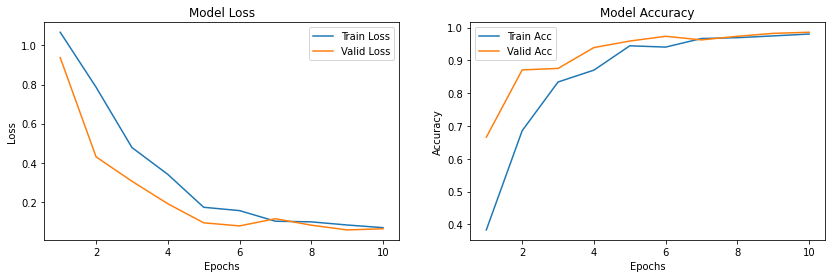

In [20]:
trainer.plot_model_results()

In [21]:
trainer.evaluate(test_dl)

Test Loss :    0.060 | Test Acc:    0.987


(0.060288155251847844, 0.9866071428571429)

In [22]:
trainer.save("model_v1.pt")

Model Saved Successfully as [model_v1.pt]


In [24]:
!ls -la | grep model_v1.pt

-rw-r--r-- 1 root root    451061 Dec  7 09:45 model_v1.pt


In [25]:
loaded_model_v1 = trainer.load("model_v1.pt")
torchinfo.summary(loaded_model_v1, input_size=(32, 3, IMAGE_SIZE, IMAGE_SIZE), device=device)

Model Loaded Successfully from [model_v1.pt]


Layer (type:depth-idx)                   Output Shape              Param #
RockPaperScissors_Model_V1               [32, 3]                   --
├─Sequential: 1-1                        [32, 32, 50, 50]          --
│    └─Conv2d: 2-1                       [32, 64, 100, 100]        1,792
│    └─ReLU: 2-2                         [32, 64, 100, 100]        --
│    └─Conv2d: 2-3                       [32, 32, 100, 100]        18,464
│    └─ReLU: 2-4                         [32, 32, 100, 100]        --
│    └─MaxPool2d: 2-5                    [32, 32, 50, 50]          --
├─Sequential: 1-2                        [32, 32, 25, 25]          --
│    └─Conv2d: 2-6                       [32, 16, 50, 50]          4,624
│    └─ReLU: 2-7                         [32, 16, 50, 50]          --
│    └─Conv2d: 2-8                       [32, 32, 50, 50]          4,640
│    └─ReLU: 2-9                         [32, 32, 50, 50]          --
│    └─MaxPool2d: 2-10                   [32, 32, 25, 25]          --
├─